<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Dummy-модель" data-toc-modified-id="Dummy-модель-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>Dummy модель</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Отчет-о-проделанной-работе." data-toc-modified-id="Отчет-о-проделанной-работе.-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Отчет о проделанной работе.</a></span></li></ul></div>

# Описание проекта
Оператору связи необходима модель для прогнозирования отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Были предоставлены персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Требование заказчика - показатель метрики AUC-ROC выше 0.85 при тестировании лучшей модели.

План работы:
1. Загрузка данных;
2. Предварительная обработка данных;
2. Исследовательский анализ данных;
3. Обучение моделей;
4. Оценка качества моделей;
5. Тестирование лучшей модели;
6. Общие выводы.

Цель проекта: Создать модель, способную предсказывать расторжение договора обслуживания для сохранения лояльных клиентов компании.

In [1]:
#!pip install skimpy -U
#!pip install phik -U
#!pip install catboost -U
#!pip install lightgbm -U
#!pip install scikit-learn -U
#!pip install optuna -U
#!pip install pandas -U
#!pip install numpy -U
#!pip install pip -U

### Импорт библиотек

In [2]:
import pandas as pd
from skimpy import clean_columns
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import phik
import numpy as np

import warnings
import catboost as cb
import lightgbm as lgb
import optuna
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from catboost.utils import (get_roc_curve,
                            get_confusion_matrix
                           )

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_validate,
                                     StratifiedKFold
                                    )
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
warnings.filterwarnings('ignore')

actual_date = '2020-02-01'
random_state = 70823


### Первичный анализ данных

In [3]:
#Создать локальную директорию datasets№
try:
    os.makedirs('datasets')
except IOError:
    pass
#выгружаю данные по клиентам
try:
    contract = pd.read_csv('datasets/contract_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')
except IOError:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [4]:
#соединим выгруженные данные в датасет
df = contract.merge(right=personal, how='left', on='customerID')
df = df.merge(right=internet, how='left', on='customerID')
df = df.merge(right=phone, how='left', on='customerID')

In [5]:
#проверим первые строки датасета
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
#размер датасета
df.shape

(7043, 20)

In [7]:
#выгружу названия столбцов для дальнейшей работы
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [8]:
#проверим пропуски
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [9]:
#проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [10]:
#проверяю на явные дубликаты
df.duplicated().sum()

0

In [11]:
#первично посмотрю распределением данных
df.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,67,3,2,4,NaN,6658,2,NaN,2,2,2,2,2,2,2,2,2,2
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Результаты первичного анализа данных:
- Данные были загружены. Датасет состоит из 7043 строк 20 столбцов;
- Есть пропуски в столбцах 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines'. Все это связано с подключенными опциями, если там пропуск, то скорее всего клиент не пользуется такой услугой и в зависимости от данных пропуски можно заменить на 'no', 'no internet', 'no phone';
- Явные и неявные дубликаты отсутствуют;
- Названия столбцов необходимо привести к единому формату до нижнего регистра и разделения с использыванием нижнего подчеркивания;
- У нас имеются данной на актуальный срок '2020-02-01', ее можно вставить в столбец 'end_date' и посчитать количество дней договора каждого клиента;
- Данные из столбца 'end_date' являются целевой переменной, ее необходимо вывести в отдельный столбец и привести к формате 0/1 (исследовать бисбаланс классов);
- Изменить тип данных дата и посчитать количество дней договора;
- Изменить тип данных в 'MonthlyCharges' и 'TotalCharges';
- Проанализировать данные с использованием Phik для проверки мультиколлинеарности признаков, удалить их при необходимости.

### Предобработка данных

In [12]:
#приведу название к правильному формату
df = clean_columns(df)
df.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
2693,3976-HXHCE,2014-02-01,No,Two year,No,Bank transfer (automatic),19.30,1417.39,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2099,2190-BCXEC,2016-10-01,No,Month-to-month,Yes,Credit card (automatic),78.85,3217.08,Female,0,Yes,No,Fiber optic,No,No,No,Yes,No,No,Yes
2184,4695-WJZUE,2019-11-01,No,Month-to-month,Yes,Electronic check,88.55,265.65,Female,1,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes
2436,6360-SVNWV,2017-07-01,No,Month-to-month,Yes,Credit card (automatic),73.55,2280.05,Female,1,No,No,Fiber optic,Yes,No,No,No,No,No,No
2951,5815-HGGHV,2018-06-01,No,One year,Yes,Mailed check,64.15,1283.0,Male,0,Yes,No,DSL,Yes,No,No,Yes,No,Yes,No


In [13]:
#заполню пропуси
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

internet_options = ['online_security', 'online_backup', 'device_protection', \
                    'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service']
df[internet_options] = df[internet_options].fillna('no_internet')

In [14]:
#проверю пропуски после заполнения
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [15]:
#создаю целевую переменную и привожу ее к бинарному формату
df['target'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [16]:
#заменю данные на актуальная дату выгрузки
df['end_date'] = df['end_date'].replace(to_replace=['No'], value=[actual_date])

In [17]:
#приведу данные к формату дату
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
#расчитаю длительность договоров каждого клиента
df['contract_duration'] = (df['end_date'] - df['begin_date']).dt.days

In [18]:
#приведу колонку к числовому типу
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').fillna(df['monthly_charges'])

In [19]:
df.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration
2230,5242-UOWHD,2016-05-01,2020-02-01,Two year,No,Mailed check,20.35,952.38,Male,0,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,1371
1975,4703-MQYKT,2018-05-01,2020-02-01,Two year,No,Mailed check,19.60,436.30,Male,0,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,641
5924,2236-HILPA,2014-12-01,2020-02-01,Two year,No,Credit card (automatic),20.65,1280.30,Male,0,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,1888
1420,8785-CJSHH,2015-02-01,2020-02-01,Month-to-month,Yes,Electronic check,99.80,6227.52,Female,0,...,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,0,1826
5518,9574-RKJIF,2017-06-01,2020-02-01,Month-to-month,Yes,Electronic check,94.40,3020.80,Male,0,...,Fiber optic,Yes,Yes,No,No,Yes,No,Yes,0,975


In [20]:
#заменю тип данных senior_citizen на object
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [21]:
#проверю есть ли клиенты без подключенных услуг
print('Количество пользователей с нулевыми общими тратами:', len(df[df['monthly_charges']>df['total_charges']]))

Количество пользователей с нулевыми общими тратами: 0


In [22]:
df.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration
3494,5569-KGJHX,2019-01-01,2019-03-01,Month-to-month,Yes,Bank transfer (automatic),85.35,170.70,Female,0,...,Fiber optic,No,No,No,No,Yes,No,Yes,1,59
6828,2005-DWQZJ,2019-06-01,2020-02-01,Two year,No,Mailed check,19.05,152.40,Female,0,...,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,245
2464,2609-IAICY,2019-11-01,2020-02-01,Month-to-month,Yes,Electronic check,77.15,231.45,Female,0,...,Fiber optic,No,No,No,No,No,No,Yes,0,92
2873,0148-DCDOS,2017-09-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),94.70,2856.15,Male,0,...,Fiber optic,No,No,No,No,Yes,Yes,Yes,0,883
2604,6481-ESCNL,2017-09-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),100.55,2945.11,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,883


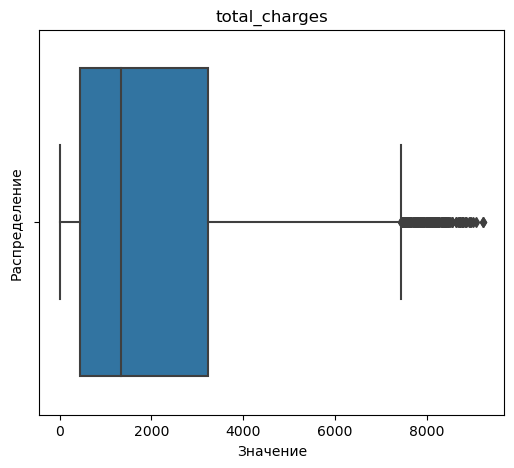

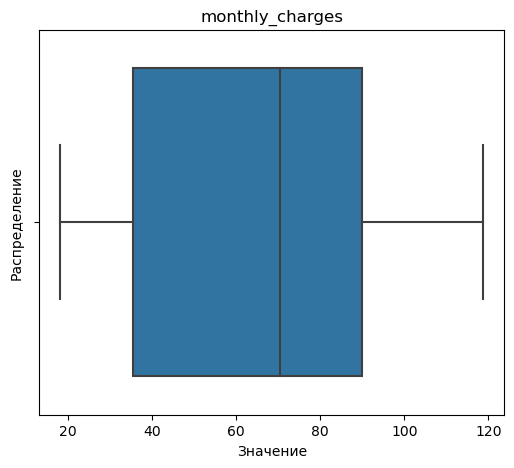

In [23]:
#проверю выбросы в  признаках 'total_charges', 'monthly_charges'
columns = ['total_charges', 'monthly_charges']

for column in columns:
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df, x=column)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Распределение')
    plt.show()

Наблюдаются незначительные выбросы в колонке 'total_charges'.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Результаты предобработки данных:
1. Названия колонок были приведены к единому формату и разделению слов с использованием нижнего пробела;
2. Пропуски были заполнены информацией, что клиент не использует телефон или интернет. Опции, связанные с интернетом, объединил в один список internet_options;
3. Создана целевая переменная и приведена к бинарному значению;
4. Данные по датам были приведены к единому формату даты;
5. Создана новая переменная - продолжительность контракта;
6. Данные в колонке 'total_charges' были приведены к числовому формату, нулевые значения были заполнены значением 'monthly_charges';
7. Наблюдаются незначительные выбросы в колонке 'total_charges'.

### Исследовательский анализ данных

In [25]:
#проверю дисбаланс классов
df['target'].value_counts(normalize=True)

target
0    0.843675
1    0.156325
Name: proportion, dtype: float64

Наблюдается сильный дисбаланс классов.

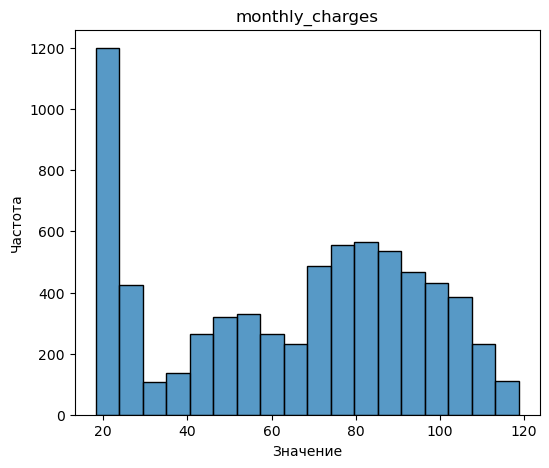

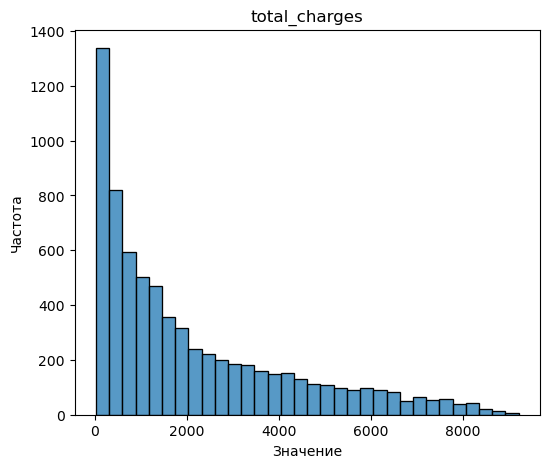

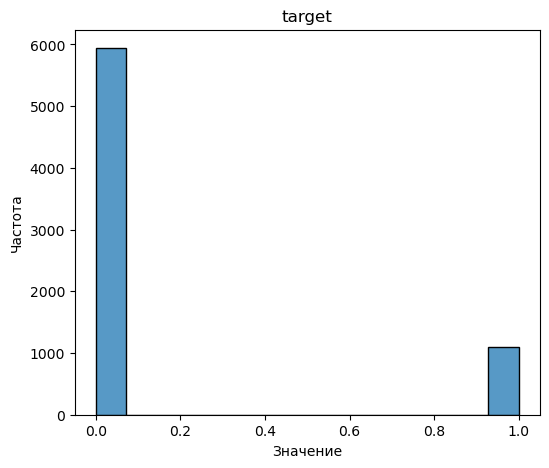

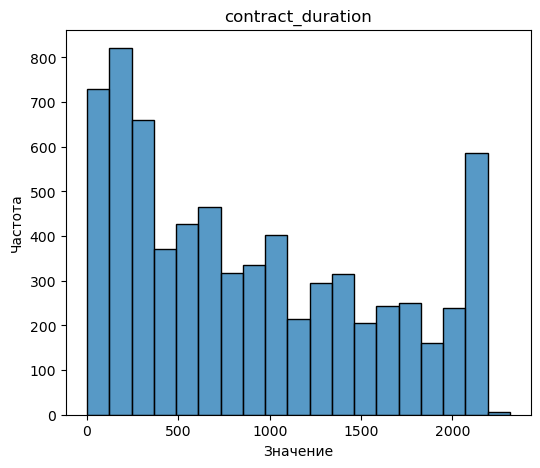

In [26]:
#построим гистограммы числовых признаков
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

for column in numeric_columns:
    plt.figure(figsize=(6, 5))
    sns.histplot(data=df, x=column)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Частота')

plt.show()

Наблюдается ненормальное распределение гребенчатого типа в числовых данных 'monthly_charges' и 'contract_suration', график смещен влево. В данных 'total_charges' наблюдается усеченное распределение с обрывом справа. Наблюдается сильный дисбаланс классов.

In [27]:
#посмотрю чисто клиентов без подключенных услуг
print('Число клиентов без подключенных услуг:', len(df[(df['internet_service'] == 'no_phone') \
                                                       & (df['multiple_lines'] == 'no_internet')]))


Число клиентов без подключенных услуг: 0


In [28]:
#создаю функцию, которая на вход принимает данные, подписи и название графика, выход - график
def plot_kde(data, xlabel=None, ylabel=None, title=None):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    kdeplot = sns.kdeplot(data, fill=True, color='blue')

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    return kdeplot

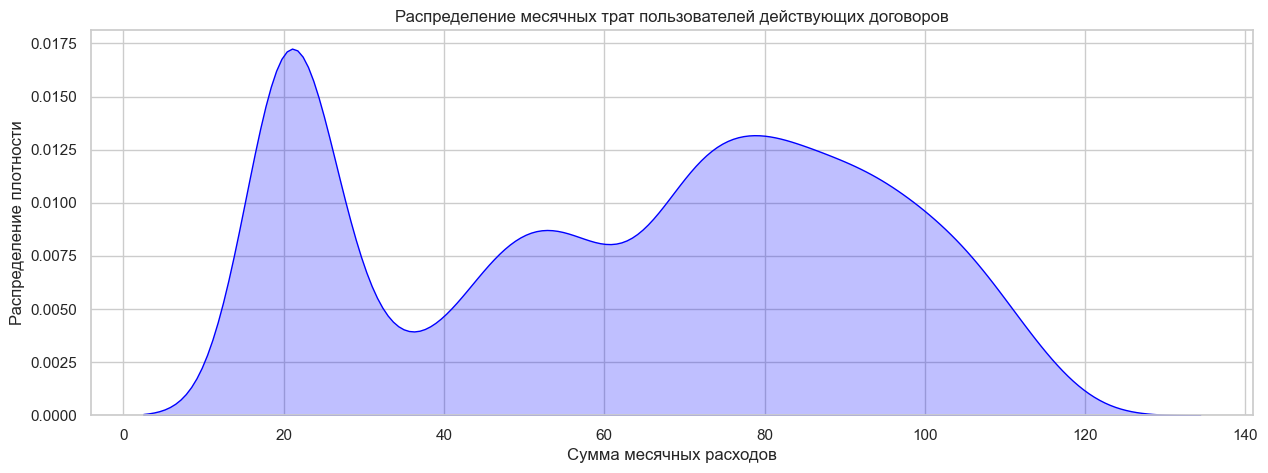

In [29]:
#изучу распределение месячных трат пользователей действующих договоров
plot_kde(df[df['target'] == 0]['monthly_charges'],
         xlabel="Сумма месячных расходов",
         ylabel="Распределение плотности",
         title="Распределение месячных трат пользователей действующих договоров");

Для действующих клиентов наблюдается два выраженных пика ежемесячных расходов: в 20 у.е. и 80 у.е.

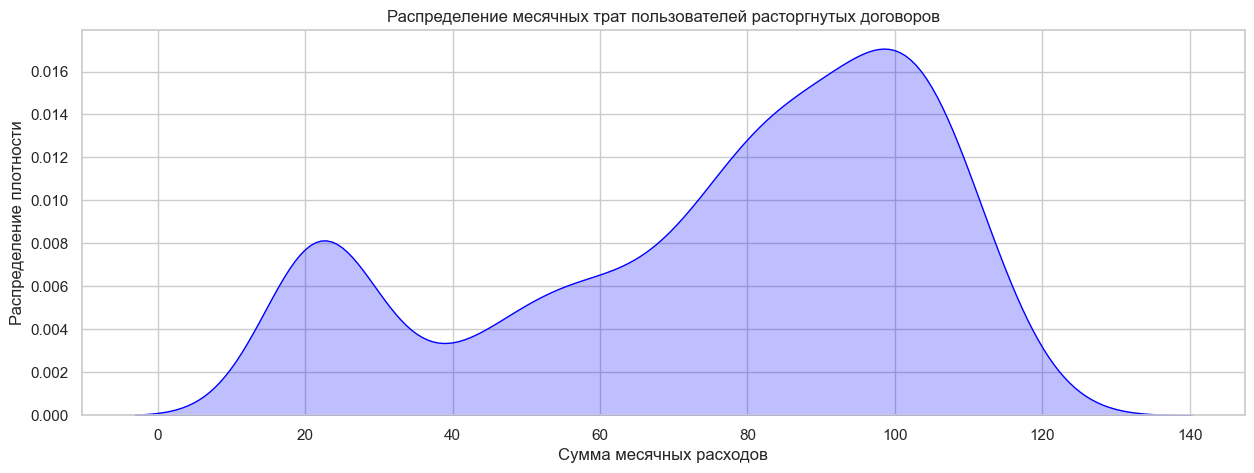

In [30]:
#изучу распределением месячных трат ушедших клиентов
plot_kde(df[df['target'] == 1]['monthly_charges'],
         xlabel="Сумма месячных расходов",
         ylabel="Распределение плотности",
         title="Распределение месячных трат пользователей расторгнутых договоров");

Для клиентов, расторгших договор обслуживания, наблюдается ярко выраженный пик ежемесячных трат в 100 у.е.. Можно сделать вывод, что клиенты с действующим обслуживанием тратят меньше, чем клиенты, которые расторгли договор.
Возможно, это связано с маркетинговой компанией по привлечению новых клиентов с выгодными условиями по ежемесячным тратам.

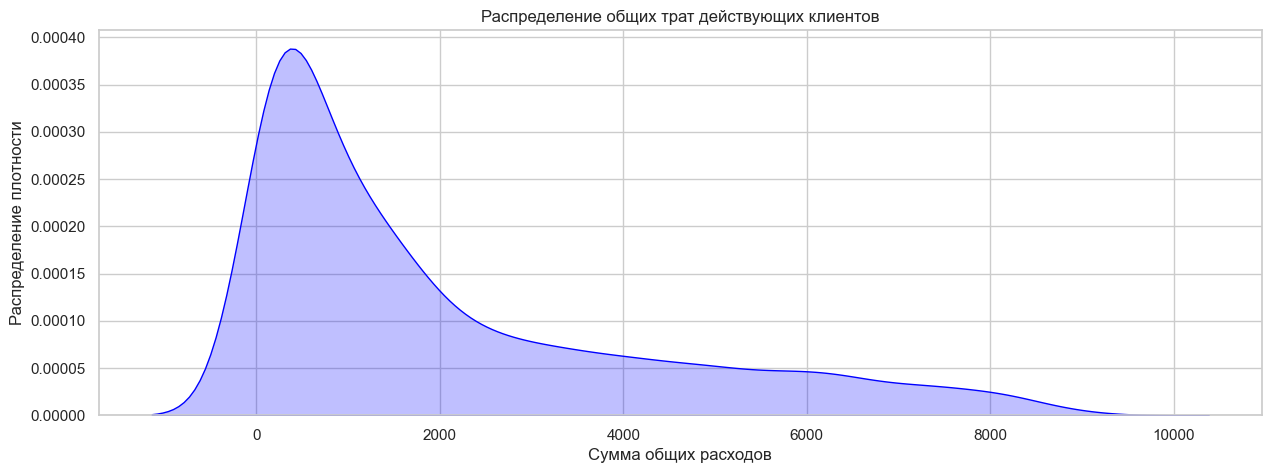

In [31]:
#рассмотрю распределении общих трат действующих клиентов
plot_kde(df[df['target'] == 0]['total_charges'],
         xlabel="Сумма общих расходов",
         ylabel="Распределение плотности",
         title="Распределение общих трат действующих клиентов");

Для действующих клиентов наблюдается пик общих трат в 400 у.е., что, возможно, связано с проведенной маркетинговой компанией.

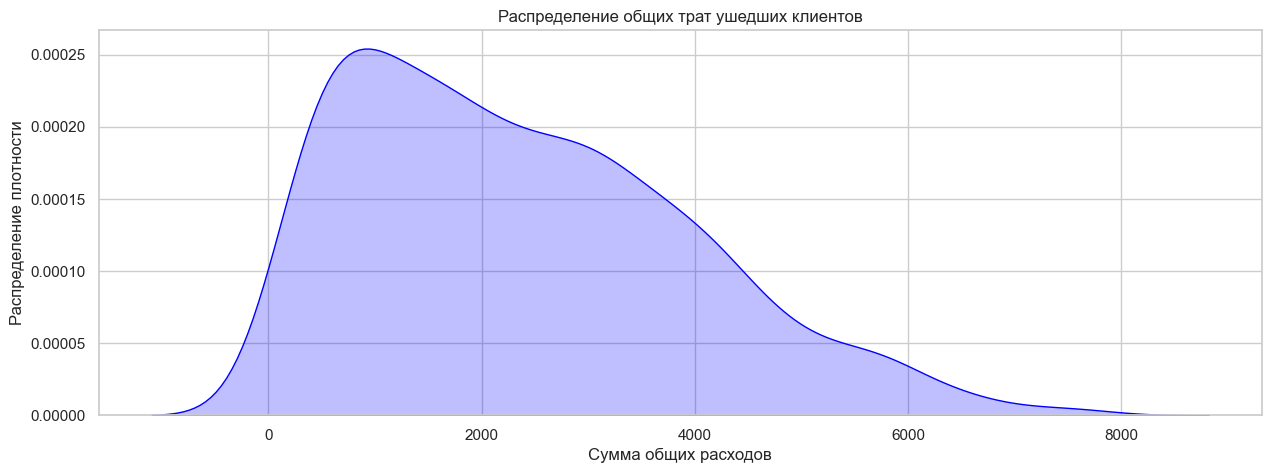

In [32]:
#рассмотрю распределение общих трат ушедших клиентов
plot_kde(df[df['target'] == 1]['total_charges'],
         xlabel="Сумма общих расходов",
         ylabel="Распределение плотности",
         title="Распределение общих трат ушедших клиентов");

Для ушедших клиентов наблюдается пик в 500 у.е., также заметны сохраняющиеся высокие общие траты ушедших клиентов.

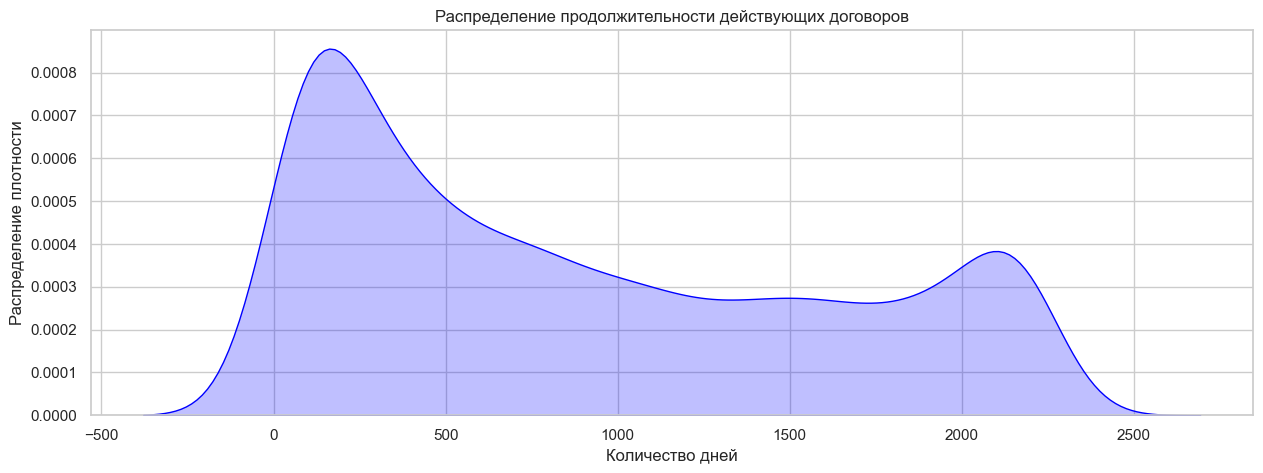

In [33]:
#изучу распределением продолжительности действующих договоров
plot_kde(df[df['target'] == 0]['contract_duration'],
         xlabel="Количество дней",
         ylabel="Распределение плотности",
         title="Распределение продолжительности действующих договоров");

Среди действующих договоров наблюдается два пика. Первый - молодые договоры до года. И второй пик договоров с продолжительностью более 2000 дней.

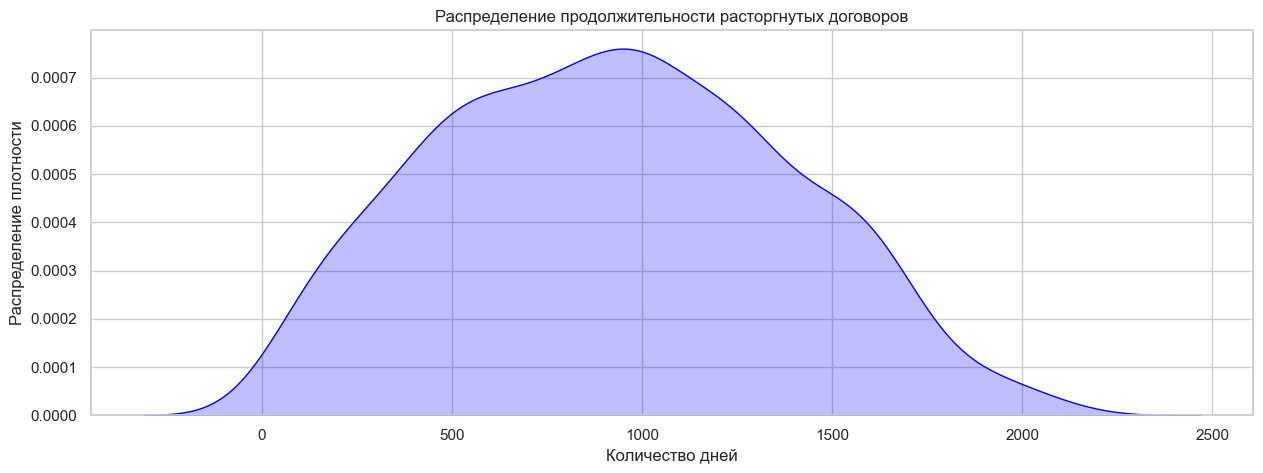

In [34]:
#изучу распределение продолжительности расторгнутых договоров
plot_kde(df[df['target'] == 1]['contract_duration'],
         xlabel="Количество дней",
         ylabel="Распределение плотности",
         title="Распределение продолжительности расторгнутых договоров");

Продолжительность расторгнутых договоров ушедших клиентов распределена нормально в диапазоне от 0 до 2000 дней, наиболее частая продолжительность - от 500 до 1500 дней.

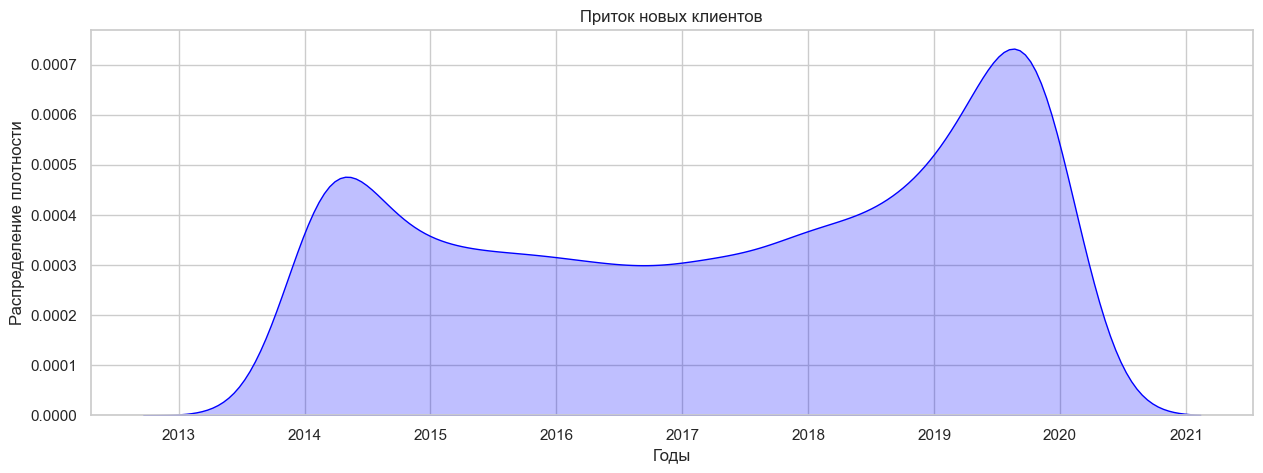

In [35]:
#рассмотрю график притока новых клиентов
plot_kde(df['begin_date'],
         xlabel="Годы",
         ylabel="Распределение плотности",
         title="Приток новых клиентов");

Наблюдается два выраженных пика. Первый пик представляет собой начало работы провайдеры и заключение первых договоров. Второй пик - увеличение притока клиентов в результате проведенной маркетинговой компании.

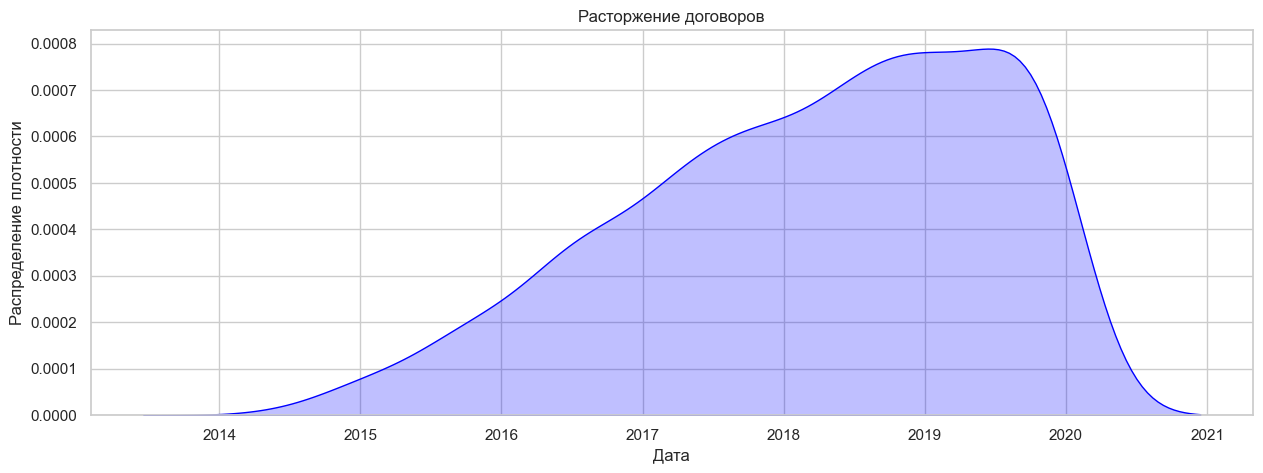

In [36]:
#рассмотрю график расторжения договоров
plot_kde(df[df['end_date'] != actual_date]['end_date'],
        xlabel='Дата',
        ylabel='Распределение плотности',
        title='Расторжение договоров');

На графике распределения расторжение договоров наблюдается равномерное увеличение количества расторгнутых договоров. Что предварительно связано с увеличением расходов ежемесячных и общих трат клиентов и отсутствия маркетинговых компаний по их удержанию.

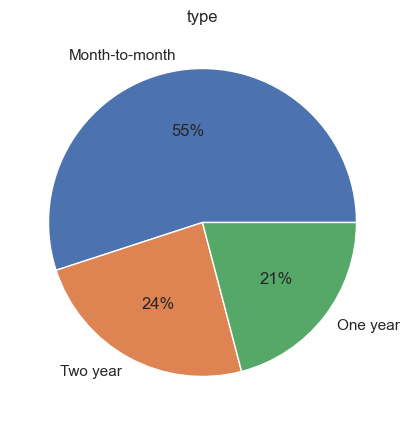

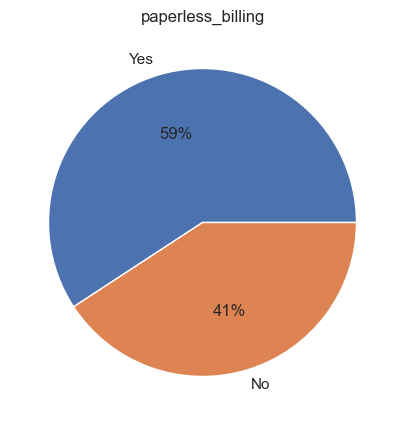

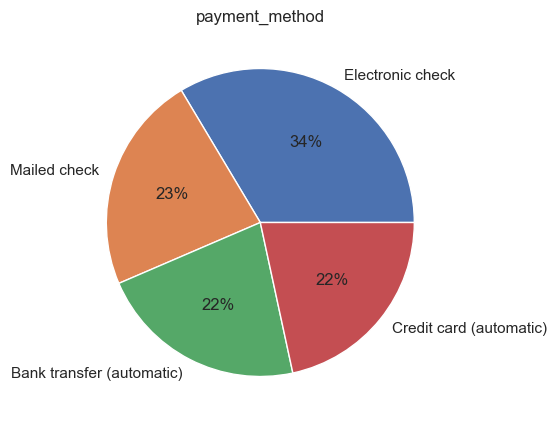

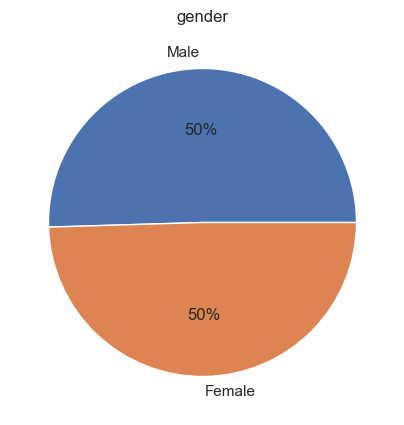

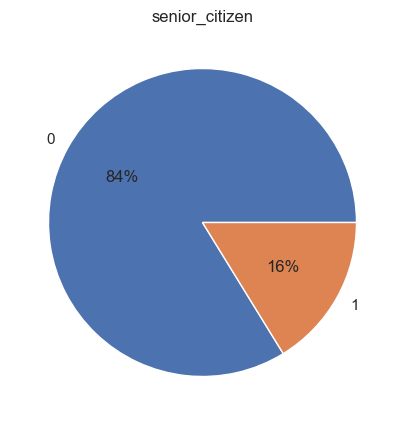

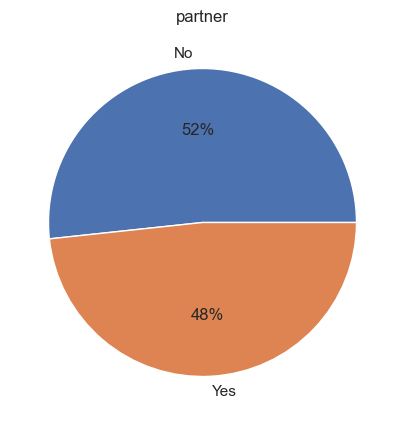

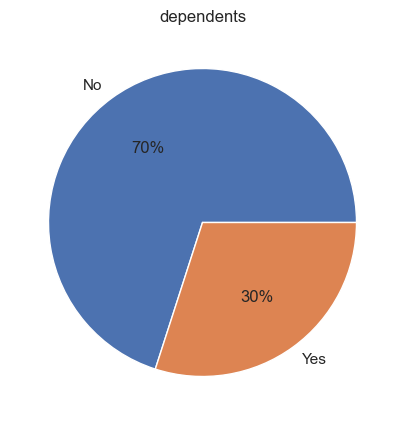

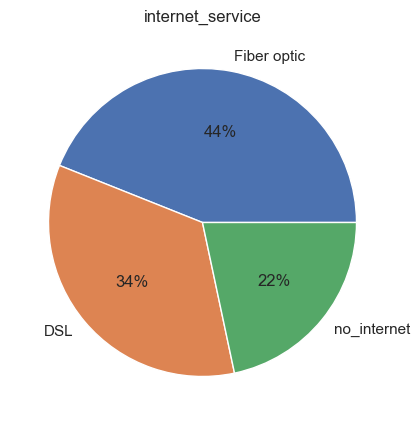

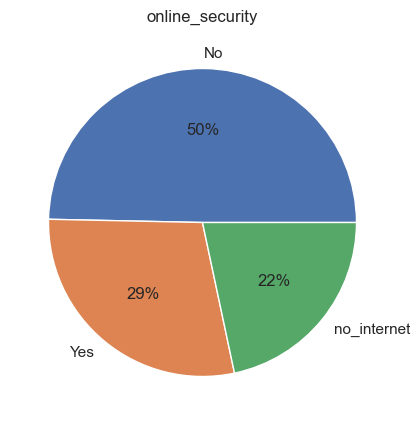

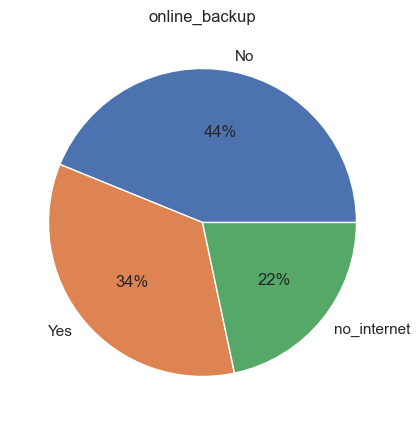

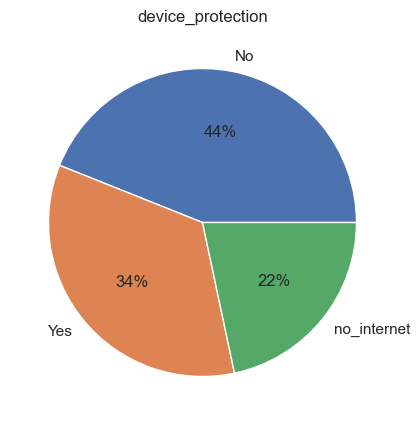

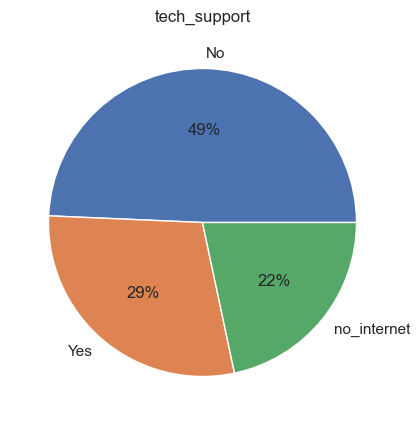

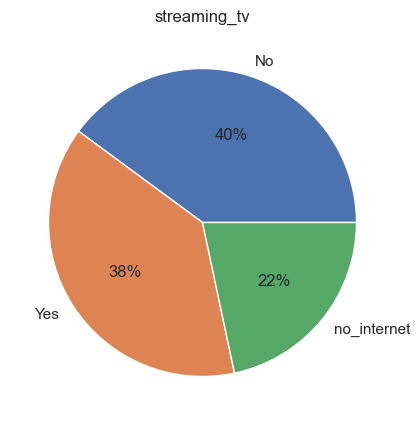

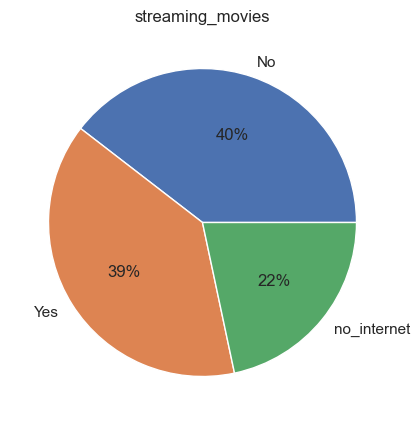

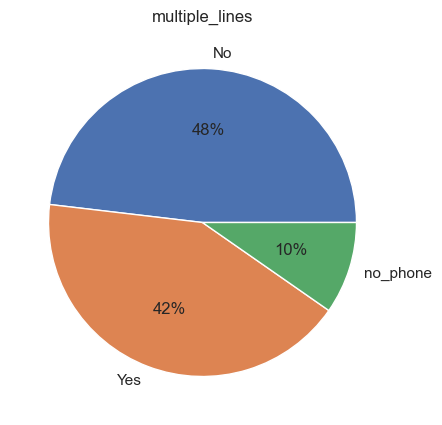

In [37]:
#рассмотрю распределение категориальных признаков
object_columns = df.drop('customer_id', axis=1).select_dtypes('object').columns.values.tolist()

for col in object_columns:
    fig, ax = plt.subplots(figsize=(5, 5))
    df[col].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_aspect('equal')

    plt.show()

Образ реального покупателя:
- предпочитает помесячную оплату;
- отказывается от электронного платежного документа;
- предпочитает удобный для себя способ оплаты услуг;
- не является пенсионером;
- не имеет иждивенцев.

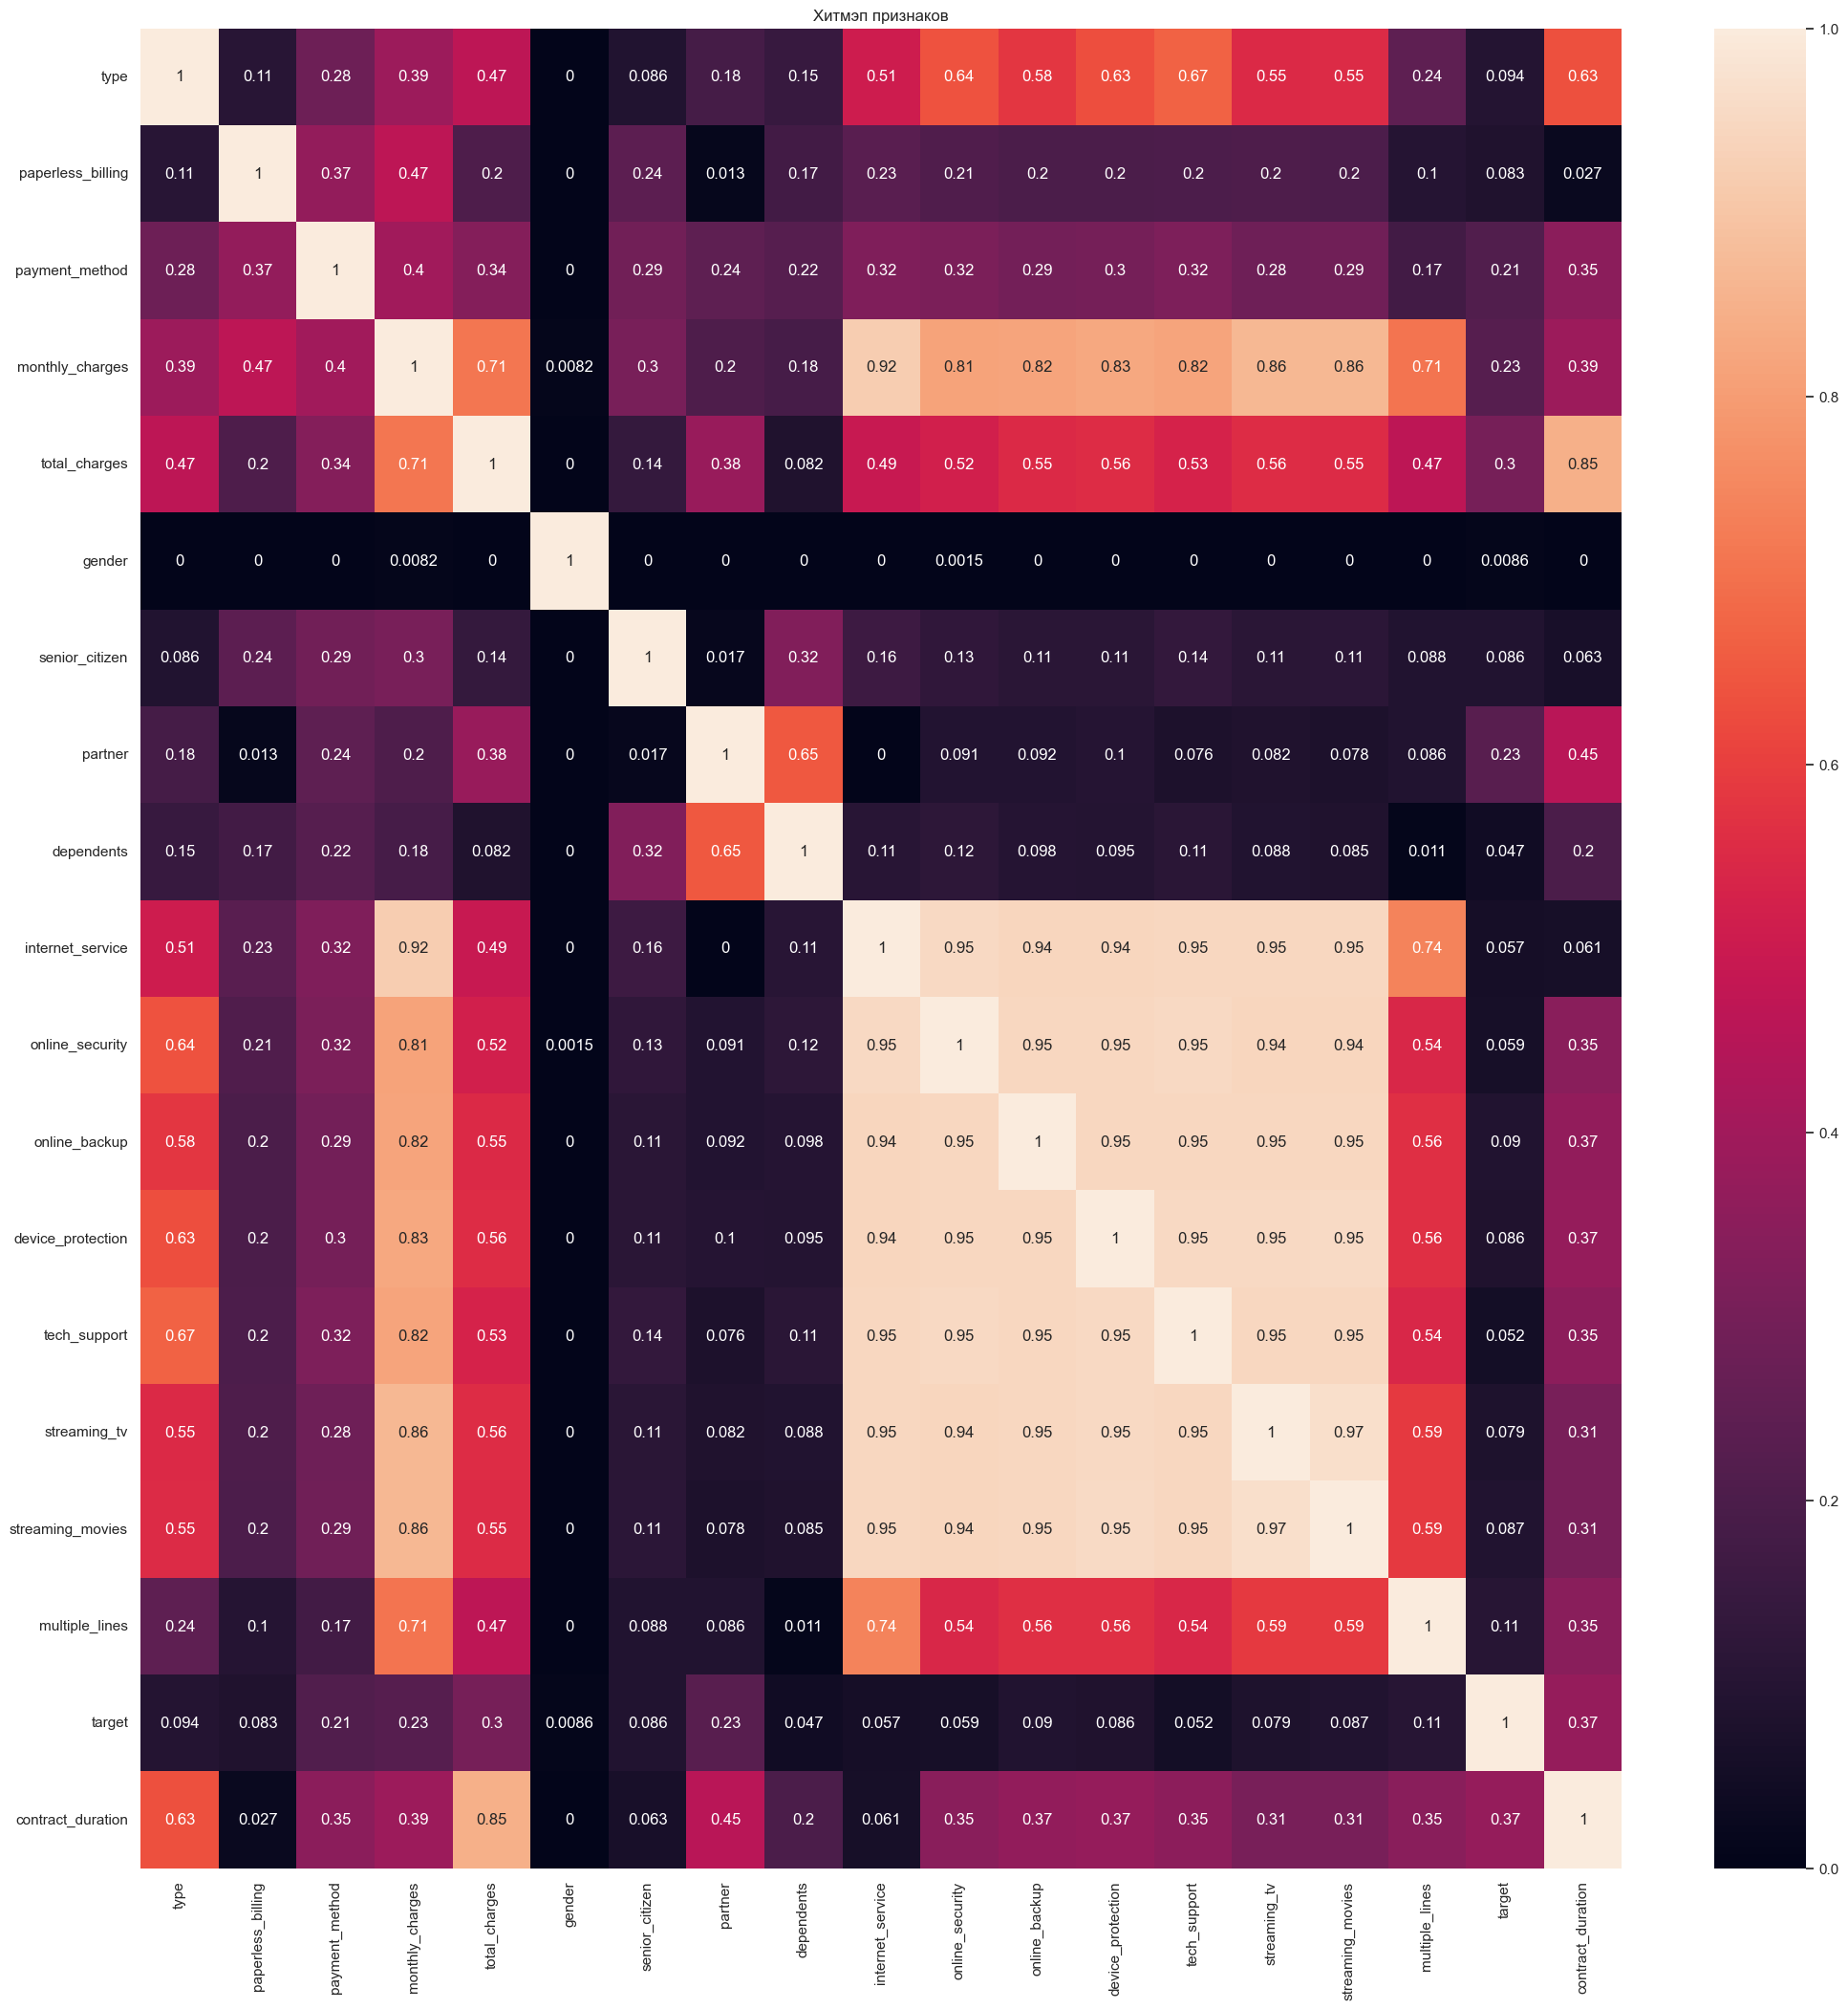

In [38]:
#рассмотрю матрицу корреляции признаков
df1 = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']

phik_corr_matrix = df1.phik_matrix(interval_cols=interval_cols)

sns.set(rc={'figure.figsize':(25,25)})

ax = plt.axes()
ax.set_title('Хитмэп признаков')
sns.heatmap(phik_corr_matrix, annot=True)

plt.show()

Результаты исследовательского анализа данных:
1. Наблюдается сильный дисбаланс классов;
2. Отсутствуют клиенты без подключенной телефонии или интернета;
3. Для действующих клиентов наблюдается два выраженных пика ежемесячных расходов: в 20 у.е. и 80 у.е. Для клиентов, расторгших договор обслуживания, наблюдается ярко выраженный пик ежемесячных трат в 100 у.е.. Можно сделать вывод, что клиенты с действующим обслуживанием тратят меньше, чем клиенты, которые расторгли договор. Возможно, это связано с маркетинговой компанией по привлечению новых клиентов с выгодными условиями по ежемесячным тратам;
4. Для действующих клиентов наблюдается пик общих трат в 400 у.е., что, возможно, связано с проведенной маркетинговой компанией. Для ушедших клиентов наблюдается пик в 500 у.е., также заметны сохраняющиеся высокие общие траты ушедших клиентов;
5. Среди действующих договоров наблюдается два пика. Первый - молодые договоры до года. И второй пик договоров с продолжительностью более 2000 дней. Продолжительность договоров ушедших клиентов распределена нормально в диапазоне от 0 до 2000 дней, наиболее частая продолжительность - от 500 до 1500 дней;
6. В графике притока новых клиентов наблюдается два выраженных пика. Первый пик представляет собой начало работы провайдеры и заключение первых договоров. Второй пик - увеличение притока клиентов в результате проведенной маркетинговой компании. На графике распределения расторжение договоров наблюдается равномерное увеличение количества расторгнутых договоров. Что предварительно связано с увеличением расходов ежемесячных и общих трат клиентов и отсутствия маркетинговых компаний по их удержанию;
7. В результате изучения матрицы корреляции признаков была обнаружено, что признак 'gender', 'dependents' и 'senior_citizen' не имеет корреляции с другими признаками и их можно удалить. Наблюдается явление мультиколлинеарности между признаками 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' их также можно удалить.

### Обучение моделей

#### Подготовка данных

In [39]:
#сохраним изначальный датасет и удалим указанные строки из датасета перед разделением на выборки
df_ori = df.copy()
df.drop(['customer_id', 'gender', 'begin_date', 'end_date', 
        'internet_service', 'online_security', 'online_backup', 
        'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
        'dependents', 'senior_citizen'], axis=1, inplace=True)
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,partner,multiple_lines,target,contract_duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Yes,no_phone,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,no_phone,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,0,153


In [40]:
# Подготовка данных для RandomForestClassifier
features = df.drop('target', axis=1)
target = df['target']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            stratify=target,
                                                                            random_state=random_state)

features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

category_columns = features.select_dtypes('object').columns.values.tolist()
numeric = features.select_dtypes(['float64', 'int64']).columns.values.tolist()

# Создаем и применяем OrdinalEncoder для категориальных признаков
encoder = OrdinalEncoder()
features_train_encoded = encoder.fit_transform(features_train[category_columns])
features_test_encoded = encoder.transform(features_test[category_columns])

# Создаем DataFrame с преобразованными категориальными признаками
features_train_encoded = pd.DataFrame(
    features_train_encoded, columns=[f'{col}_encoded' for col in category_columns]
)
features_test_encoded = pd.DataFrame(
    features_test_encoded, columns=[f'{col}_encoded' for col in category_columns]
)

# Добавляем преобразованные категориальные признаки и числовые признаки
features_train_encoded = pd.concat([features_train_encoded, features_train[numeric]], axis=1)
features_test_encoded = pd.concat([features_test_encoded, features_test[numeric]], axis=1)


In [41]:
#подготовка данных для Catboost и LightGBM
features = df.drop('target', axis=1)
target = df['target']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            stratify=target,
                                                                            random_state=random_state)

features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

columns = features.select_dtypes('object').columns.values.tolist()

for col in columns:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

categorical_features = np.where(features_train.dtypes == 'category')[0]

In [42]:
print('Тренировочная выборка:')
print(features_train.shape)
print(features_train_encoded.shape)
print(target_train.shape)
print('Тестовая выборка:')
print(features_test.shape)
print(features_test_encoded.shape)
print(target_test.shape)

Тренировочная выборка:
(5282, 8)
(5282, 8)
(5282,)
Тестовая выборка:
(1761, 8)
(1761, 8)
(1761,)


Данные были разделены на выборки в соотношении 3:1

# Обучение моделей

##### Random Forest Classifier

In [43]:
# проведу подбор гиперпараметров с использованием GridSearchCV
#parameters = {'n_estimators': [100, 300, 500],
#    'max_depth': [None] + [i for i in range(2, 7)],
#    'min_samples_split': [2, 5, 10],
#   'min_samples_leaf': [1, 2, 4]
#}
#rf_classifier = RandomForestClassifier(random_state=random_state)
#scoring = {'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}
#refit_metric = 'accuracy'
# Осуществим подбор гиперпараметров по сетке в кросс-валидации для первой модели
#rfc_tuner = GridSearchCV(estimator=rf_classifier,
#                         param_grid=parameters,
#                         cv=10,
#                         scoring=scoring,
#                         refit=refit_metric,
#                         n_jobs=-1,
#                         verbose=3)

#rfc_tuner.fit(features_train_encoded, target_train)
#display(rfc_tuner.best_params_)
#display(rfc_tuner.best_score_)

In [44]:
#подобранные гиперпараметры
rfc_params = {
    'max_depth': None,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 300,
    'random_state': random_state
}


In [45]:
start_rf = time.time()
# Создание модели RandomForest
rfc_model = RandomForestClassifier(**rfc_params)

# Определение метрик
scoring = ['roc_auc','accuracy']

# Создание StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
rfc_cv_scores = pd.DataFrame(cross_validate(rfc_model,
                                            features_train_encoded,
                                            target_train,
                                            cv=cv,
                                            scoring=scoring,
                                            verbose=10,
                                            n_jobs=-1))
end_rf = time.time()
execution_rf = end_rf - start_rf


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [46]:
rfc_roc_auc = rfc_cv_scores['test_roc_auc'].mean()
rfc_accuracy = rfc_cv_scores['test_accuracy'].mean()
print('Значение ROC-AUC Random Forest Classifier',rfc_roc_auc)
print('Значение Accuracy Random Forest Classifier',rfc_accuracy)

Значение ROC-AUC Random Forest Classifier 0.8282427256406855
Значение Accuracy Random Forest Classifier 0.8669078438118174


##### LightGBM

In [47]:
# Подбор гиперпараметров с OPTUNA
#def objective(trial: optuna.Trial) -> float:
#    data, target = features_train, target_train
#    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

#    param = {
#        "objective": "binary",
#        "metric": "auc",
#        "verbosity": -1,
#        "bagging_freq": 1,
#        "n_estimators": trial.suggest_int("n_estimators", 400, 1900, step=100),
#        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
#        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
#        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
#        
#    }

#    gbm = lgb.LGBMClassifier(**param)

#    gbm.fit(
#        train_x,
#        train_y,
#        eval_set=[(valid_x, valid_y)],
#        verbose=0,
#        early_stopping_rounds=100,
#    )

#    preds = gbm.predict_proba(valid_x)
#    scoring = roc_auc_score(valid_y, preds[:, 1])

#    return scoring

#if __name__ == "__main__":
#    study = optuna.create_study(
#        pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize"
#    )
    
#    study.optimize(objective, n_trials=50, timeout=600)
#print("Number of finished trials: {}".format(len(study.trials)))
        
#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [48]:
#подобранные гиперпараметры
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "bagging_freq": 1,
    "n_estimators": 1100,
    "learning_rate": 0.10125156843849718,
    "num_leaves": 178,
    "subsample": 0.74935684753569,
    "colsample_bytree": 0.10591147634101988,
    "min_data_in_leaf": 15,
    'random_state': random_state
}

In [49]:
start_lgb = time.time()
# Создание модели LightGBM
lgb_model = lgb.LGBMClassifier(**lgb_params)

# Определение метрик
scoring = ['roc_auc','accuracy']

# Создание StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
lgb_cv_scores = pd.DataFrame(cross_validate(lgb_model,
                                            features_train,
                                            target_train,
                                            cv=cv,
                                            scoring=scoring,
                                            verbose=0,
                                            n_jobs=-1))

end_lgb = time.time()
execution_lgb = end_lgb - start_lgb


In [50]:
lgb_roc_auc = lgb_cv_scores['test_roc_auc'].mean()
lgb_accuracy = lgb_cv_scores['test_accuracy'].mean()
print('Значение ROC-AUC LightGBM',lgb_roc_auc)
print('Значение Accuracy LightGBM',lgb_accuracy)

Значение ROC-AUC LightGBM 0.8900401142642782
Значение Accuracy LightGBM 0.9108280654224362


##### Catboost

In [51]:
# Подбор гиперпараметров с OPTUNA
#def objective(trial: optuna.Trial) -> float:
#    data, target = features_train, target_train
#    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

#    param = {
#        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, step=0.01),
#        "depth": trial.suggest_int("depth", 1, 10, step=1),
#        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2, 10, step=1),
#        "iterations": trial.suggest_int("iterations", 400, 1900, step=100),
#        "subsample": trial.suggest_float("subsample", 0.05, 1, log=True),
#        "loss_function": "Logloss",
#        "cat_features": categorical_features    
#    }

#    cb = CatBoostClassifier(**param)

#    cb.fit(
#        train_x,
#        train_y,
#        eval_set=[(valid_x, valid_y)],
#        verbose=0,
#        early_stopping_rounds=100,
#    )

#    preds = cb.predict_proba(valid_x)
#    scoring = roc_auc_score(valid_y, preds[:, 1])

#    return scoring

#if __name__ == "__main__":
#    study = optuna.create_study(
#        pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize"
#    )
    
#    study.optimize(objective, n_trials=50, timeout=600)
#print("Number of finished trials: {}".format(len(study.trials)))
        
#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [52]:
#подобранные гиперпараметры
cb_param = {
    'learning_rate': 0.491,
    'depth': 2,
    'l2_leaf_reg': 2,
    'iterations': 1600,
    'subsample': 0.5774320403804581,
    'eval_metric': "AUC",
    'loss_function': "CrossEntropy",
    'custom_metric': "Accuracy",
    'random_state': random_state,
    'cat_features': categorical_features.tolist()
}

In [53]:
start_cb = time.time()
# Создание модели Catboost
cb_model = cb.CatBoostClassifier(**cb_param, verbose=0)

# Определение метрик
scoring = ['roc_auc','accuracy']

# Создание StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
cb_cv_scores = pd.DataFrame(cross_validate(cb_model,
                                            features_train,
                                            target_train,
                                            cv=cv,
                                            scoring=scoring,
                                            verbose=0,
                                            n_jobs=-1))
end_cb = time.time()
execution_cb = end_cb - start_cb

In [54]:
cb_roc_auc = cb_cv_scores['test_roc_auc'].mean()
cb_accuracy = cb_cv_scores['test_accuracy'].mean()

print('Значение ROC-AUC Catboost',cb_roc_auc)
print('Значение Accuracy Catboost',cb_accuracy)

Значение ROC-AUC Catboost 0.9255625602762759
Значение Accuracy Catboost 0.932411269745707


##### Dummy модель

In [55]:
start_dm = time.time()
#cоздание Dummy модели
dummy_model = DummyClassifier(strategy='prior')
dummy_model.fit(features_train, target_train)

dummy_predictions = dummy_model.predict(features_test)
dummy_proba = dummy_model.predict_proba(features_test)

dummy_auc_roc = roc_auc_score(target_test, dummy_proba[:,1])
dummy_accuracy = accuracy_score(target_test, dummy_predictions)

end_dm = time.time()
execution_dm = end_dm - start_dm

print('Значение ROC-AUC', dummy_auc_roc)
print('Значение Accuracy', dummy_accuracy)

Значение ROC-AUC 0.5
Значение Accuracy 0.8438387279954571


In [56]:
data = {
    'Модель': ['Random Forest Classifier', 'LightGBM', 'Catboost', 'Dummy'],
    'Значение ROC-AUC': [rfc_roc_auc, lgb_roc_auc, cb_roc_auc, dummy_auc_roc],
    'Значение Accuracy': [rfc_accuracy, lgb_accuracy, cb_accuracy, dummy_accuracy],
    'Время обучения(s)': [execution_rf, execution_lgb, execution_cb, execution_dm]
}

result = pd.DataFrame(data)
print('Итоговая таблица результатов обучения моделей')
display(result)

Итоговая таблица результатов обучения моделей


,Модель,Значение ROC-AUC,Значение Accuracy,Время обучения(s)
0,Random Forest Classifier,0.828243,0.866908,1.368271
1,LightGBM,0.890040,0.910828,1.558567
2,Catboost,0.925563,0.932411,5.048998
3,Dummy,0.500000,0.843839,0.003258


Результаты обучения моделей:
1. Было обучено 3 модели машинного обучения (Random Forest Classifier, LightGBM, Catboost) и одна dummy model;
2. Для оценки эффективности моделей было использовано две метрики: ROC-AUC и accuracy;
3. Для вычисления метрик было использована кросс-валидация StratifiedKFold;
3. Наиболее эффективной моделей согласно итоговой таблице стала Catboost, значение ROC-AUC - 0.932411,  Accuracy - 0.925563, время обучения(s) - 5;
4. В качестве финальной модели для тестирования на тестовой выборке будет использована Catboost.

### Тестирование модели

In [57]:
#тестируем модель на тестовой выборке
cb_model = cb.CatBoostClassifier(**cb_param, verbose=0)
cb_model.fit(features_train, target_train)
cb_predictions = cb_model.predict(features_test)

cb_predictions_proba = cb_model.predict_proba(features_test)
probabilities_cb = cb_predictions_proba[:,1]
fpr_cb,tpr_cb,thresholds=roc_curve(target_test,probabilities_cb)

auc_roc_cb = roc_auc_score(target_test,probabilities_cb)
conf_matrix = confusion_matrix(target_test, cb_predictions)
cb_accuracy = accuracy_score(target_test, cb_predictions)
print('Значение метрики Accuracy для Catboost', cb_accuracy)
print('Значение метрики AUC-ROC для Catboost', auc_roc_cb)

Значение метрики Accuracy для Catboost 0.9295854628052242
Значение метрики AUC-ROC для Catboost 0.9247620212896122


Значение метрики Accuracy равное 0.9295 означает, что алгоритм обучения Catboost правильно классифицировал около 92.95% всех примеров в тестовой выборке.

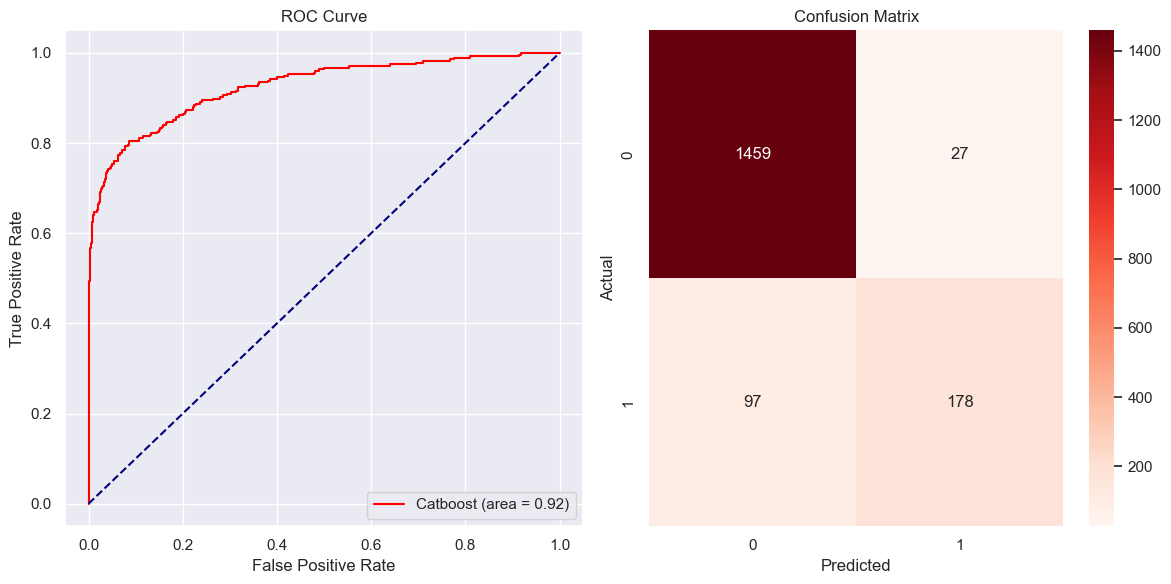

In [58]:
plt.figure(figsize=(12, 6))

# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(fpr_cb, tpr_cb, color='red', label='Catboost (area = %0.2f)' % auc_roc_cb)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

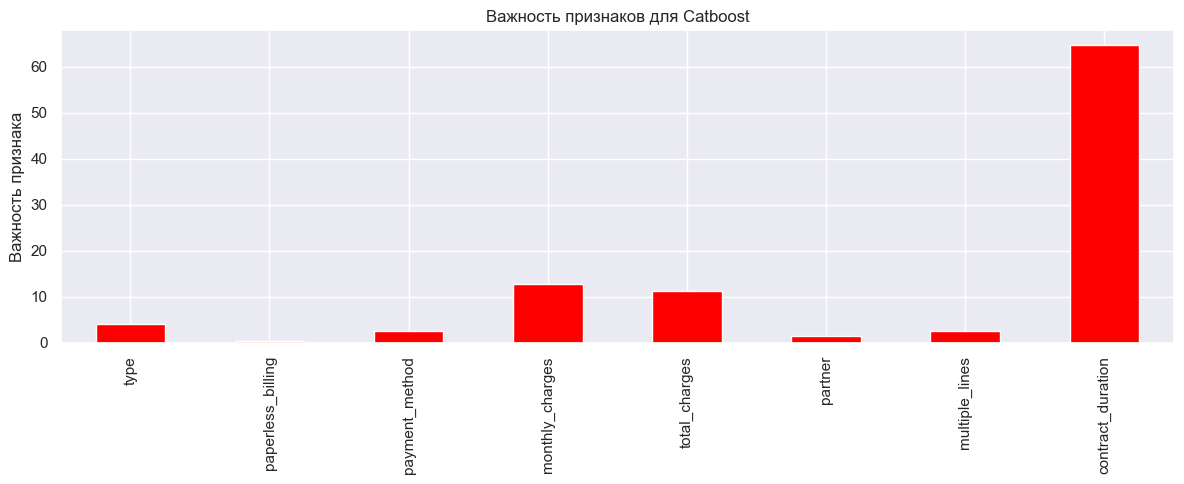

In [59]:
feature_importance_cb = cb_model.get_feature_importance()

feature_importance_cb = pd.Series(feature_importance_cb, index=features_test.columns)

plt.show()

fig, ax = plt.subplots(figsize=(12,5))

feature_importance_cb.plot.bar(ax=ax, color='red', grid=True)
ax.set_title("Важность признаков для Catboost")
ax.set_ylabel('Важность признака')
fig.tight_layout()

Результаты тестирования модели:
1. Модель на основе Catboost показала следующие результаты при тестированнии: ROC_AUC = 0.92, Accuracy = 0.92. Значение метрики Accuracy равное 0.9295 означает, что алгоритм обучения Catboost правильно классифицировал около 92.95% всех примеров в тестовой выборке.
2. В целях данной работы для нас наиболее важны позитивные предсказания модели. Согласно матрице ошибок,модель сделала:
- 178 истинно положительных предсказаний, соответственно компания может осуществить действия для удержания 178 клиентов;
- 97 ложно-негативных предсказаний, в связи с этим компания может потерять 97 клиентов, не осуществив действий по удержанию;
- 27 ложно - положительных предсказаний, это клиенты, которые не планировали отказываться от обслуживания, но модель предсказала их уход;
- 1459 истинно негативных предсказаний,  это клиенты, которые действительно не будут расторгать договор;
3. Наиболее важными признаками являются длительность договора, суммарные траты и ежемесячные траты.

### Общие выводы

1. Данные были загружены. Датасет состоит из 7043 строк 20 столбцов. Названия колонок были приведены к единому формату и разделению слов с использованием нижнего пробела. Пропуски были заполнены информацией, что клиент не использует телефон или интернет. Опции, связанные с интернетом, объединил в один список internet_options. Создана целевая переменная и приведена к бинарному значению. Создана новая переменная - продолжительность контракта;
2. Наблюдается сильный дисбаланс классов. Отсутствуют клиенты без подключенной телефонии или интернета. Для действующих клиентов наблюдается два выраженных пика ежемесячных расходов: **в 20 у.е. и 80 у.е.** Для клиентов, расторгших договор обслуживания, наблюдается ярко выраженный пик ежемесячных трат в **100 у.е.**. Можно сделать вывод, что клиенты с действующим обслуживанием тратят меньше, чем клиенты, которые расторгли договор. Возможно, это связано с маркетинговой компанией по привлечению новых клиентов с выгодными условиями по ежемесячным тратам. Для действующих клиентов наблюдается пик общих трат в 400 у.е., что, возможно, связано с проведенной маркетин. В графике притока новых клиентов наблюдается два выраженных пика. Первый пик представляет собой начало работы провайдеры и заключение первых договоров. Второй пик - увеличение притока клиентов в результате проведенной маркетинговой компании. **На графике распределения расторжение договоров наблюдается равномерное увеличение количества расторгнутых договоров. Что предварительно связано с увеличением расходов ежемесячных и общих трат клиентов и отсутствия маркетинговых компаний по их удержанию**. В результате изучения матрицы корреляции признаков была обнаружено, что признак 'gender', 'dependents' и 'senior_citizen' не имеет корреляции с другими признаками и их можно удалить. Наблюдается явление мультиколлинеарности между признаками 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' их также можно удалить.
3. Было обучено 3 модели машинного обучения (Random Forest Classifier, LightGBM, Catboost) и одна dummy model. Для оценки эффективности моделей было использовано две метрики: ROC-AUC и accuracy. Для вычисления метрик было использована кросс-валидация StratifiedKFold. Наиболее эффективной моделей стала **Catboost**, значение **ROC-AUC - 0.925563**, **Accuracy - 0.932411**, время обучения(s) - 5. **В качестве финальной модели для тестирования на тестовой выборке будет использована Catboost**.
4. **Модель на основе Catboost показала следующие результаты при тестированнии: ROC_AUC = 0.92, Accuracy = 0.92**. Модель сделала **97 ложно-негативных предсказаний** и **27 ложно-положительных**. В целях данной работы для нас наиболее важны позитивные предсказания модели, чтобы компания могла осуществлять действия для удержания клиентов. **Правильных позитивных предсказаний модель сделала 178**. Наиболее важными признаками являются длительность договора, суммарные траты и ежемесячные траты.
5. По итогам работы, модель Catboost можно рекомендовать к использованию, её применение поможет сохранить клиентов компании. В дальнейшей работе следует проводить работу с целью дальнейшей минимизации ложно-негативных предсказаний модели.

### Отчет о проделанной работе.

План работы предполагал следующие действия:

1. Загрузка данных;
2. Предварительная обработка данных;
2. Исследовательский анализ данных;
3. Обучение моделей;
4. Оценка качества моделей;
5. Тестирование лучшей модели;
6. Общие выводы.

Работы была выполнена, согласно плану и дополнительных этапов не потребовалось. Основным этапом работы можно выделить предварительную обработку данных и подбор гиперпараметров. Из сложностей в ходе работы хочу отметить низкие значения метрик при обучении и длительность подбора гиперпараметрой для их увеличения.

Технические особенности проекта:
- Предоставленный датасет состоял из 7043 строк 20 столбцов. Названия колонок были приведены к единому формату и разделению слов с использованием нижнего пробела. Пропуски были заполнены информацией, что клиент не использует телефон или интернет. Опции, связанные с интернетом, объединил в единый список internet_options. Создана целевая переменная и приведена к бинарному значению. Создана новая переменная - продолжительность контракта;

- Итоговый список признаков для обучения модели: 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'partner', 'multiple_lines', 'target',
       'contract_duration'. 
       Удалены следующие признаки: 'internet_service', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'dependents', 'senior_citizen'.
       Признаки были преобразованы с использоваем OrdinalEncoder;

- Разбиение данных на выборки проведено со стратификацией и соотношением тренировочных данных к тестовым 75:25. На полученных выборках сделано кодирование методом OrdinalEncoder для моделей RandomForest. Для обучения Catboost и LightGBM категориальные признаки были преобразованы в тип 'category'.

Полученные размерности выборок:
1. Тренировочная выборка: тренировочная выборка (5282, 8), тренировочная выборка с кодированием OrdinalEncoder (5282, 8), целевая переменная (5282,)
2. Тестовая выборка:тренировочная выборка (1761, 8), тренировочная выборка с кодированием OrdinalEncoder(1761, 8), целевая переменная (1761,)


Сводная таблица исследованных моделей и их метрика на кросс-валидации.

| Модель|Значение ROC-AUC|Значение Accuracy|Время обучения(s)|
| ------------- | ------------- | ------------- | ------------- |
|Random Forest Classifier|0.828243|0.866908|1.420617|
|LightGBM|0.879510|0.904391|2.231022|
|Catboost|0.925563|0.932411	|5.097762|
|Dummy|0.500000|0.843839|0.003060|

Итоговой моделью стал классификатор Catboost, со следующими гиперпараметрами:

| Гиперпараметр|Значение|
| ------------- | ------------- |
|'learning_rate'| 0.491|
|'depth'| 2 |
|'l2_leaf_reg'| 2 |
|'iterations'| 1600 |
|'subsample'| 0.5774320403804581 |

Значение метрик при тестировании финальной модели:

| Метрика|Значение|
| ------------- | ------------- |
|ROC_AUC|0.92|
|Accuracy|0.92|

В целях данной работы для нас наиболее важны позитивные предсказания модели. Согласно матрице ошибок,модель сделала:
- 178 истинно положительных предсказаний, соответственно компания может осуществить действия для удержания 178 клиентов;
- 97 ложно-негативных предсказаний, в связи с этим компания может потерять 97 клиентов, не осуществив действий по удержанию;
- 27 ложно - положительных предсказаний, это клиенты, которые не планировали отказываться от обслуживания, но модель предсказала их уход;
- 1459 истинно негативных предсказаний,  это клиенты, которые действительно не будут расторгать договор;

Наиболее важными признаками для обучения модели являются длительность договора, суммарные траты и ежемесячные траты.